<a href="https://colab.research.google.com/github/MathieuFan22/Mirada-Examen-ML-M2-ISPM/blob/Mathieu/PoketraFinday-Mirada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## EDA et préparation initiale des données

,transaction_id,step,type,amount,customer_id,age,is_fraud
0,38d8cd1a-ab64-48a8-982b-547db096f8a5,421,PAYMENT,311000,C13646530,24,0
1,2440928e-8a4c-4e74-a9c5-6329668be13d,325,PAYMENT,399600,C9452763,25,0
2,973c2a3c-5676-477c-ac30-81334b01e90d,565,PAYMENT,7500,C31260354,38,0
3,5413d0f4-b4f0-406f-bd91-91de1dce573c,511,TRANSFER,94000,C8841991,26,0
4,c9fa99e2-42c8-4dd8-94ba-aa3e44bfdd98,63,CASH_OUT,15000,C3176716,26,0



Statistique Descriptive:


,step,amount,age,is_fraud
count,30000.000000,3.000000e+04,30000.000000,30000.000000
mean,361.139733,1.474855e+05,34.516800,0.019833
std,207.894173,4.114664e+05,16.067294,0.139430
min,0.000000,1.000000e+02,18.000000,0.000000
25%,180.000000,1.750000e+04,23.000000,0.000000
50%,364.000000,4.930000e+04,28.000000,0.000000
75%,541.000000,1.360000e+05,43.000000,0.000000
max,719.000000,1.921400e+07,90.000000,1.000000


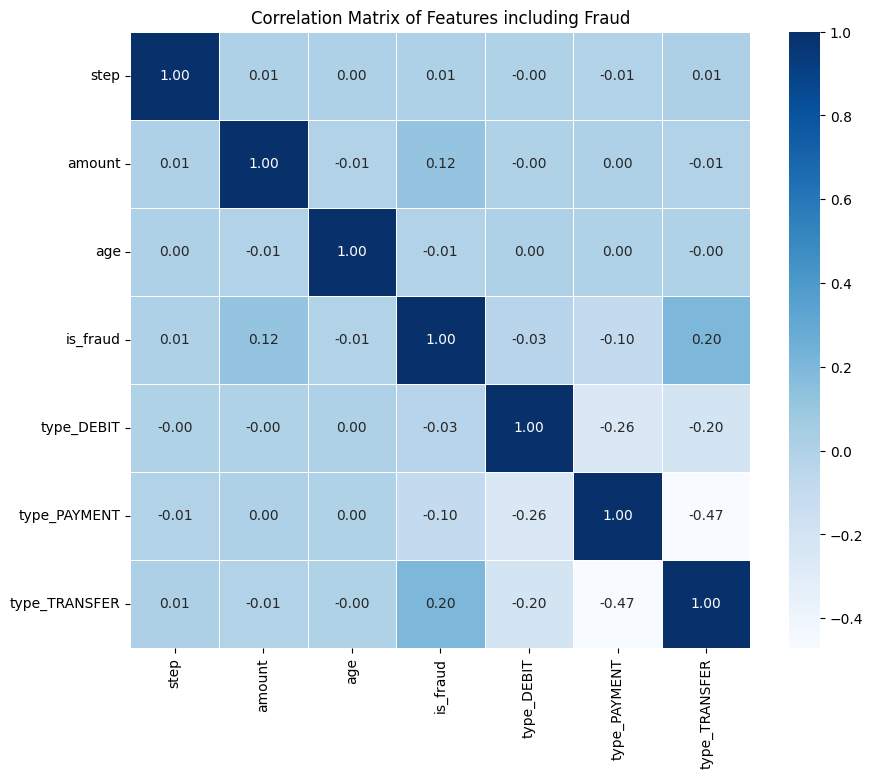

In [216]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score)
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

df = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
display(df.head())


print("\nStatistique Descriptive:")
display(df.describe())

columns_to_drop_if_present = ['transaction_id', 'customer_id']
for col in columns_to_drop_if_present:
    if col in df.columns:
        df = df.drop(columns=[col])


df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True)

correlation_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features including Fraud')
plt.show()

## Analyser la distribution de la variable cible



Distribution de 'is_fraud':
is_fraud
0    29405
1      595
Name: count, dtype: int64


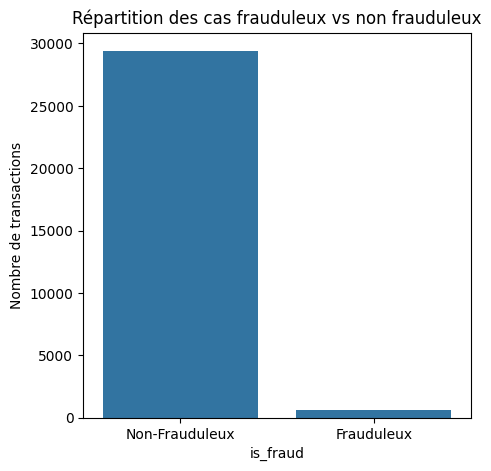

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Distribution de 'is_fraud':")
fraud_counts = df['is_fraud'].value_counts()
print(fraud_counts)


plt.figure(figsize=(5, 5))
sns.countplot(x='is_fraud', data=df)
plt.title('Répartition des cas frauduleux vs non frauduleux')
plt.ylabel('Nombre de transactions')
plt.xticks(ticks=[0, 1], labels=['Non-Frauduleux', 'Frauduleux'])
plt.show()


## Analyse exploratoire des données

### Par type :

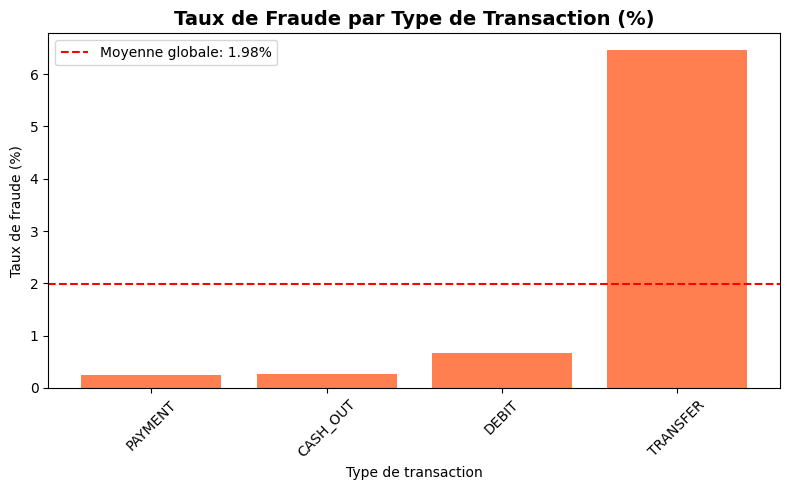

In [215]:
fraud_by_type = df.groupby('type')['is_fraud'].agg(['sum', 'count', 'mean'])
fraud_by_type['fraud_rate'] = fraud_by_type['mean'] * 100
fraud_by_type = fraud_by_type.sort_values('fraud_rate', ascending=True)
fraud_pct = df['is_fraud'].value_counts(normalize=True) * 100

plt.figure(figsize=(8,5))

plt.bar(fraud_by_type.index, fraud_by_type['fraud_rate'], color='coral')
plt.title('Taux de Fraude par Type de Transaction (%)', fontsize=14, fontweight='bold')
plt.ylabel('Taux de fraude (%)')
plt.xlabel('Type de transaction')
plt.axhline(fraud_pct[1], color='red', linestyle='--', label=f'Moyenne globale: {fraud_pct[1]:.2f}%')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


On remarque que le type de transaction "Transfer" a le pourcentage le plus élevé

### Par step :

On a fait l'analyse des transactions frauduleuses par jour et par heure en utilisant la colonne "Step"

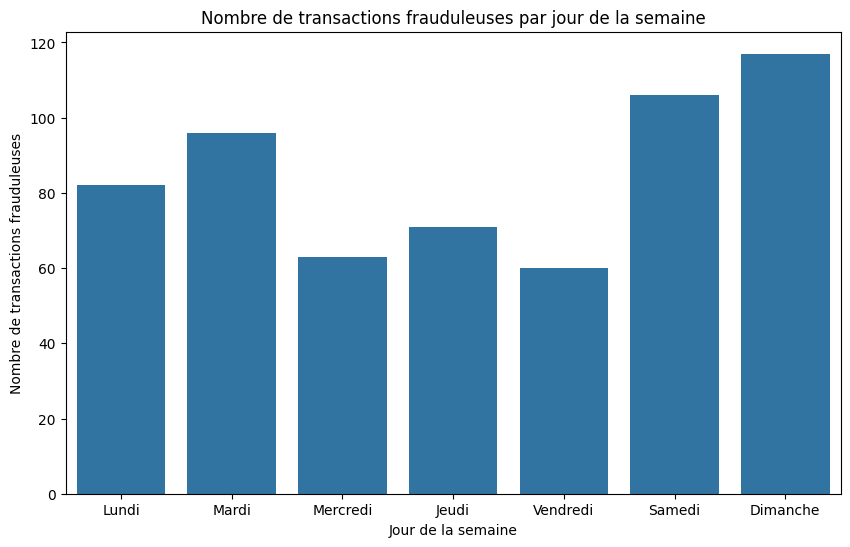

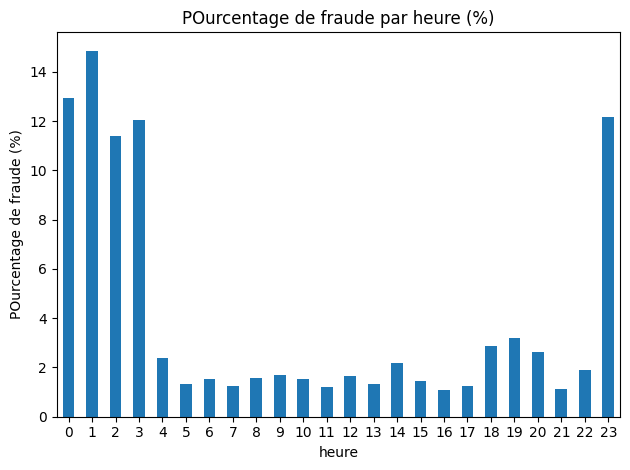

In [204]:
# Convertir step → jour et heure
jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
df_tmp_step = df.copy()
df_tmp_step['heure'] = (df_tmp_step['step'] - 1) % 24
df_tmp_step['jour'] = ((df_tmp_step['step'] - 1) // 24) % 7
df_tmp_step['jour'] = df_tmp_step['jour'].apply(lambda x: jours_semaine[x])

# Compter les transactions frauduleuses par jour
fraude_par_jour = df_tmp_step[df_tmp_step['is_fraud'] == 1].groupby('jour').size().reindex(jours_semaine)

# Diagramme en barres
plt.figure(figsize=(10,6))
sns.barplot(x=fraude_par_jour.index, y=fraude_par_jour.values)
plt.title("Nombre de transactions frauduleuses par jour de la semaine")
plt.ylabel("Nombre de transactions frauduleuses")
plt.xlabel("Jour de la semaine")
plt.show()
print('\n')
df_tmp_step['heure'] = ((df_tmp_step['step'] - 1) % 24).astype(int)

hourly = df_tmp_step.groupby('heure')['is_fraud'].mean() * 100  # en %


hourly.plot(kind='bar', title='POurcentage de fraude par heure (%)')


plt.ylabel("POurcentage de fraude (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


On remarque que entre 23h et 3h que les fraudes sont plus fréquentes

### Par montant :

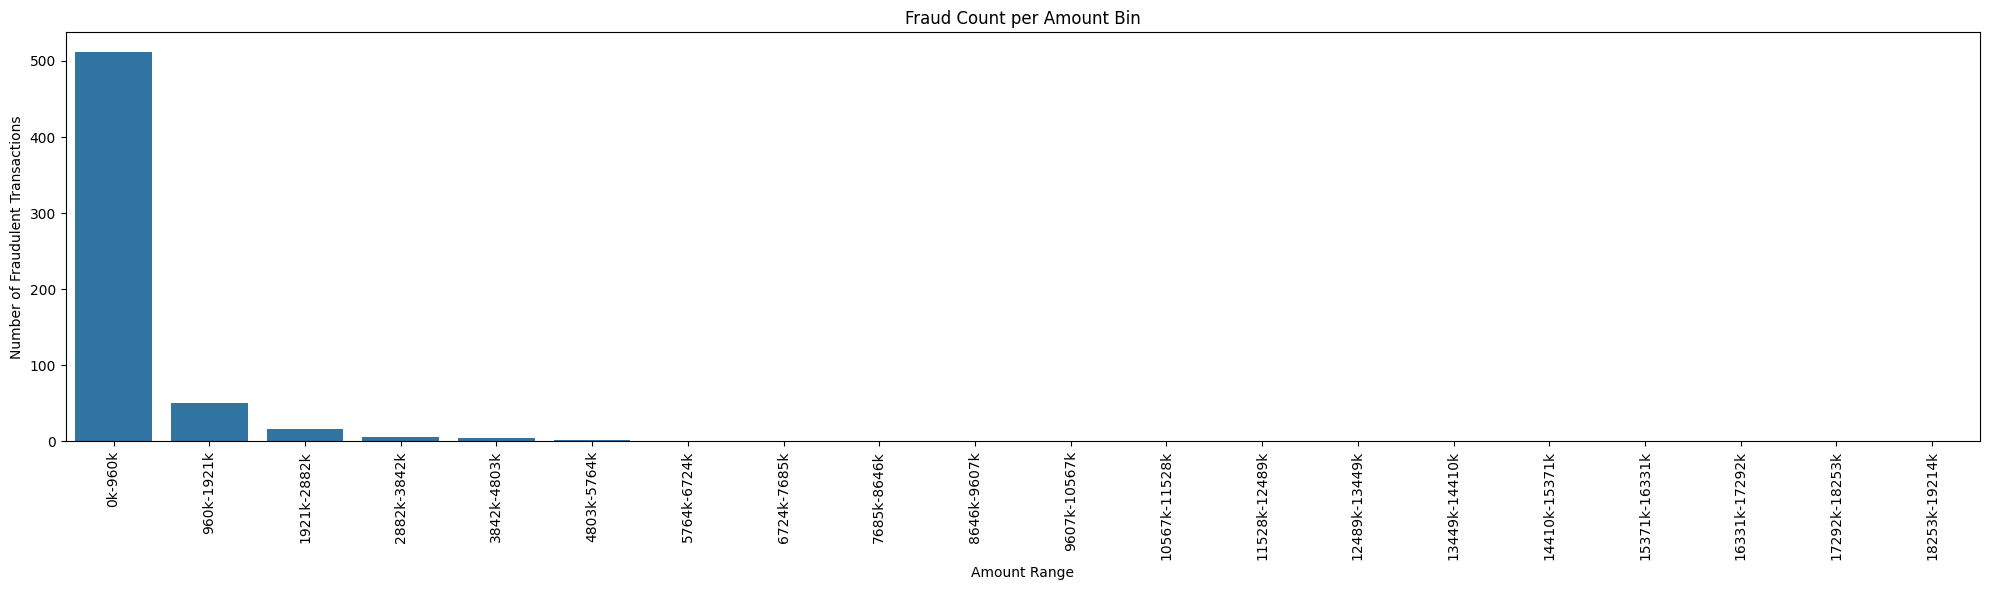

In [217]:
import numpy as np

bins = np.linspace(100, 19214000, 21)
labels = [f"{int(bins[i]/1000)}k-{int(bins[i+1]/1000)}k" for i in range(len(bins)-1)]

df_tmp_amount = df.copy()
df_tmp_amount['amount_bin'] = pd.cut(df_tmp_amount['amount'], bins=bins, labels=labels, include_lowest=True)

fraud_counts_by_amount = df_tmp_amount[df_tmp_amount['is_fraud'] == 1].groupby('amount_bin').size()

plt.figure(figsize=(20,6))
sns.barplot(x=fraud_counts_by_amount.index, y=fraud_counts_by_amount.values)
plt.xticks(rotation=90)
plt.xlabel("Amount Range")
plt.ylabel("Number of Fraudulent Transactions")
plt.title("Fraud Count per Amount Bin")
plt.tight_layout()
plt.show()


On remarque que entre 0 Ariary et 960 000 Ariary que les fraudes sont plus fréquentes.

/tmp/ipython-input-4130719496.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_by_age = df_tmp_age.groupby('age_group')['is_fraud'].mean() * 100


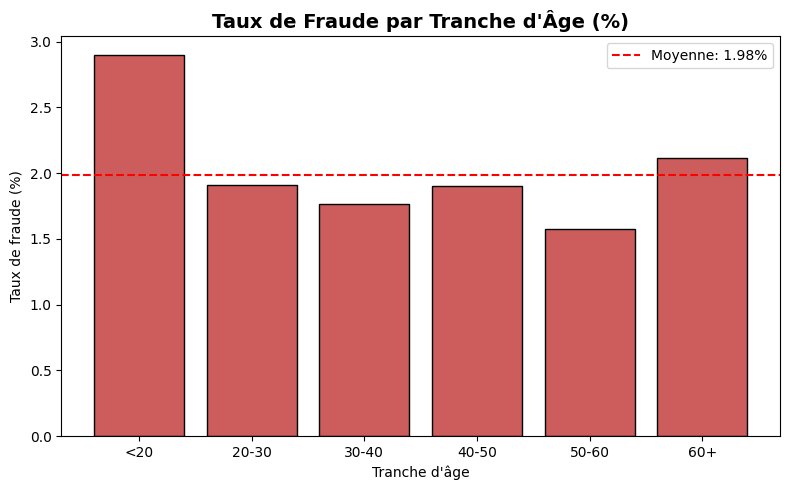

In [206]:
age_bins = [0, 20, 30, 40, 50, 60, 100]
df_tmp_age = df.copy()
df_tmp_age['age_group'] = pd.cut(df_tmp_age['age'], bins=age_bins, labels=['<20', '20-30', '30-40', '40-50', '50-60', '60+'])

# Calculer le taux de fraude par tranche d'âge
fraud_by_age = df_tmp_age.groupby('age_group')['is_fraud'].mean() * 100
fraud_pct = df_tmp_age['is_fraud'].value_counts(normalize=True) * 100

# Graphique en barres
plt.figure(figsize=(8,5))
plt.bar(range(len(fraud_by_age)), fraud_by_age.values, color='indianred', edgecolor='black')
plt.title("Taux de Fraude par Tranche d'Âge (%)", fontsize=14, fontweight='bold')
plt.xlabel("Tranche d'âge")
plt.ylabel("Taux de fraude (%)")
plt.xticks(range(len(fraud_by_age)), fraud_by_age.index)
plt.axhline(fraud_pct[1], color='red', linestyle='--', label=f"Moyenne: {fraud_pct[1]:.2f}%")
plt.legend()
plt.tight_layout()
plt.show()

In [207]:
def create_features(df):
    """Créer de nouvelles features pertinentes"""
    df_tmp = df.copy()


    df['hour_of_day'] = (df['step'] - 1) % 24
    df['day_of_week'] = ((df['step'] - 1) // 24) % 7
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_night'] = (df['hour_of_day'] < 6).astype(int)  # 00h-06h
    df['is_late_night'] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] < 6)).astype(int)


    df['time_period'] = pd.cut(df['hour_of_day'],
                                bins=[0, 6, 12, 18, 24],
                                labels=[0, 1, 2, 3],
                                include_lowest=True).astype(int)

    df['amount_log'] = np.log1p(df['amount'])
    df['amount_squared'] = df['amount'] ** 2
    df['amount_sqrt'] = np.sqrt(df['amount'])

    amount_90 = df['amount'].quantile(0.90)
    df['is_high_amount'] = (df['amount'] > amount_90).astype(int)

    df['age_squared'] = df['age'] ** 2
    df['is_senior'] = (df['age'] >= 60).astype(int)
    df['is_young'] = (df['age'] <= 25).astype(int)

    df['night_high_amount'] = df['is_night'] * df['is_high_amount']
    df['weekend_high_amount'] = df['is_weekend'] * df['is_high_amount']

    return df

train_df = create_features(df)
test_df = create_features(df_test)


print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (30000, 20)
Test shape: (10000, 21)


## Préparation des données

In [212]:
exclude_cols = ['transaction_id', 'customer_id', 'is_fraud']

X = train_df.drop(columns=exclude_cols, errors='ignore')
y = train_df['is_fraud']

X_test_final = test_df.drop(columns=['transaction_id', 'customer_id'], errors='ignore')

X = pd.get_dummies(X, columns=['type'], drop_first=True)
X_test_final = pd.get_dummies(X_test_final, columns=['type'], drop_first=True)

X_test_final = X_test_final.reindex(columns=X.columns, fill_value=0)

print(f"Features préparées: {X.shape[1]} colonnes")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")
print(f"Distribution y_train:\n{y_train.value_counts(normalize=True)}")

# Standardisation après split
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print("Standardisation appliquée correctement!")



Features préparées: 21 colonnes
X_train: (24000, 21), X_val: (6000, 21)
Distribution y_train:
is_fraud
0    0.980167
1    0.019833
Name: proportion, dtype: float64
Standardisation appliquée correctement!


## BASELINE: RÉGRESSION LOGISTIQUE


RÉSULTATS BASELINE:
              precision    recall  f1-score   support

    Légitime       1.00      0.86      0.92      5881
      Fraude       0.12      0.92      0.21       119

    accuracy                           0.86      6000
   macro avg       0.56      0.89      0.57      6000
weighted avg       0.98      0.86      0.91      6000


F1-Score Baseline: 0.2095


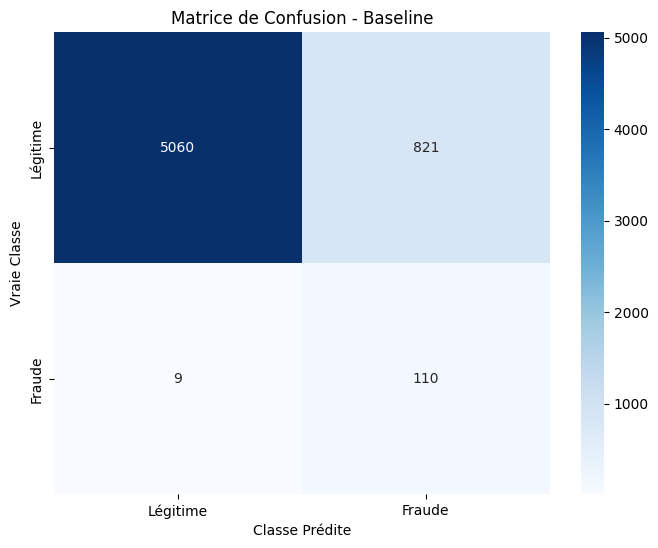

In [211]:

# Modèle avec class_weight pour gérer le déséquilibre
baseline_model = LogisticRegression(max_iter=1000,
                                     class_weight='balanced',
                                     random_state=42)

baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_val_scaled)


print("\nRÉSULTATS BASELINE:")
print(classification_report(y_val, y_pred_baseline,
                           target_names=['Légitime', 'Fraude']))

baseline_f1 = f1_score(y_val, y_pred_baseline)
print(f"\nF1-Score Baseline: {baseline_f1:.4f}")


cm_baseline = confusion_matrix(y_val, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Légitime', 'Fraude'],
            yticklabels=['Légitime', 'Fraude'])
plt.title('Matrice de Confusion - Baseline')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

## MODÈLE AVANCÉ: RANDOM FOREST + SMOTE

SMOTE appliqué: (24000, 21) → (47048, 21)

 RÉSULTATS RANDOM FOREST:
              precision    recall  f1-score   support

    Légitime       1.00      0.96      0.98      5881
      Fraude       0.29      0.88      0.44       119

    accuracy                           0.96      6000
   macro avg       0.65      0.92      0.71      6000
weighted avg       0.98      0.96      0.97      6000


F1-Score Random Forest: 0.4421
Amélioration: 0.2326 (111.0%)


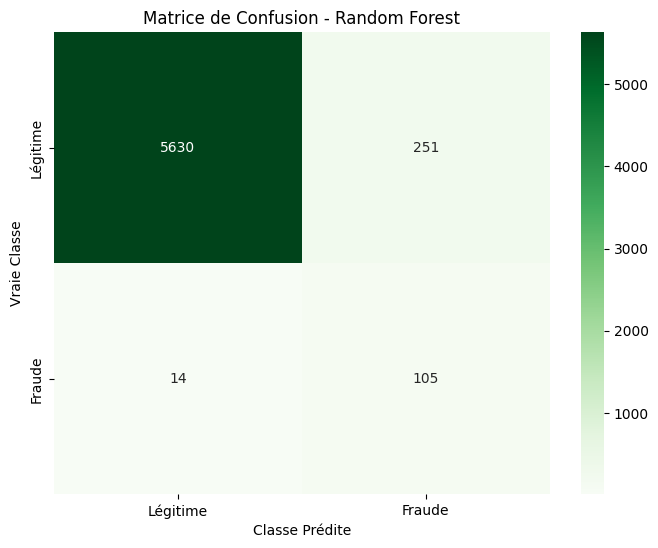

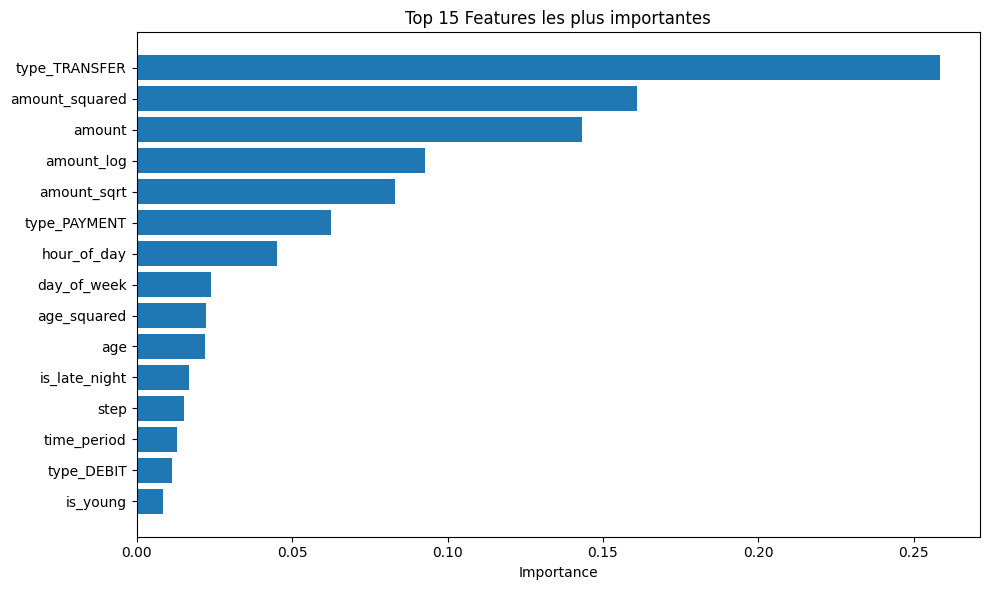

In [213]:
# Appliquer SMOTE sur le train set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"SMOTE appliqué: {X_train_scaled.shape} → {X_train_balanced.shape}")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=15,
                                  min_samples_split=10,
                                  min_samples_leaf=5,
                                  class_weight='balanced',
                                  random_state=42,
                                  n_jobs=-1)

rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_val_scaled)

# Évaluation
print("\n RÉSULTATS RANDOM FOREST:")
print(classification_report(y_val, y_pred_rf,
                           target_names=['Légitime', 'Fraude']))

rf_f1 = f1_score(y_val, y_pred_rf)
print(f"\nF1-Score Random Forest: {rf_f1:.4f}")
print(f"Amélioration: {(rf_f1 - baseline_f1):.4f} ({(rf_f1/baseline_f1 - 1)*100:.1f}%)")

# Matrice de confusion
cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Légitime', 'Fraude'],
            yticklabels=['Légitime', 'Fraude'])
plt.title('Matrice de Confusion - Random Forest')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()
print('\n')

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Features les plus importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()




## Génération du submission.*csv*

In [214]:
# Choisir le meilleur modèle (comparaison F1-Score)
if rf_f1 > baseline_f1:
    print(f"Meilleur modèle: Random Forest (F1={rf_f1:.4f})")
    final_model = rf_model
    final_predictions = final_model.predict(X_test_scaled)
else:
    print(f"Meilleur modèle: Baseline (F1={baseline_f1:.4f})")
    final_model = baseline_model
    final_predictions = final_model.predict(X_test_scaled)

submission = pd.DataFrame({
    'transaction_id': test_df['transaction_id'],
    'is_fraud': final_predictions
})


submission.to_csv('submission.csv', index=False)


print(f"Fraudes prédites: {final_predictions.sum()} ({final_predictions.sum()/len(final_predictions)*100:.2f}%)")
print(f"\nAperçu:")
print(submission.head(10))

from google.colab import files
files.download('submission.csv')

Meilleur modèle: Random Forest (F1=0.4421)
Fraudes prédites: 622 (6.22%)

Aperçu:
                         transaction_id  is_fraud
0  f9d47afa-6e9f-45a1-a443-afb5132e9986         0
1  a3159433-df38-44d2-b6e1-3920b6f2a42f         0
2  27b30f3c-7688-489f-9c77-d70981bf1a05         1
3  c3566535-87b7-40d5-ac21-7874a193af11         0
4  26ec3542-7f49-4252-b906-78157c647db8         0
5  263251d5-df93-4ee0-8beb-f392a062e777         1
6  9c9eb6d7-ad99-48aa-b87b-8256b00bbfe2         0
7  86a9f7cf-65fe-4d87-9f51-4bab9fdbabf7         0
8  5d69da88-fff8-48a4-8bc4-74353aa077e0         0
9  5455bbc4-2c84-4ee6-9678-5c142d790f54         0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>